2024-02-05 11:20:43-08:00
                     temp_air  wind_speed  ghi  dni  dhi  total_clouds  \
2024-02-05 11:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 12:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 13:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 14:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 15:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 16:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 17:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 18:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 19:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 20:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 21:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 22:20:43       NaN         NaN  NaN  NaN  NaN           NaN   
2024-02-05 2

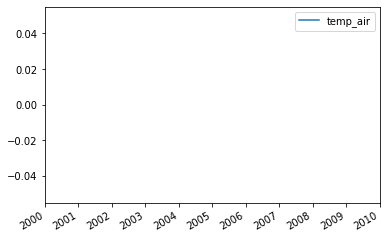

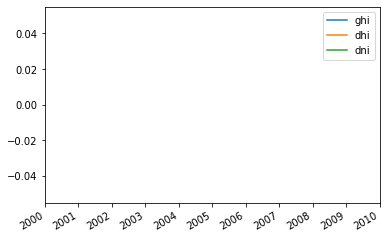

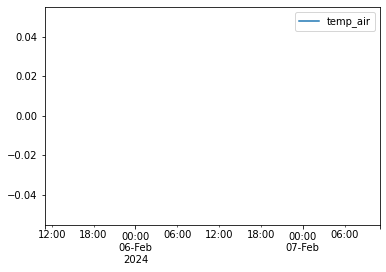

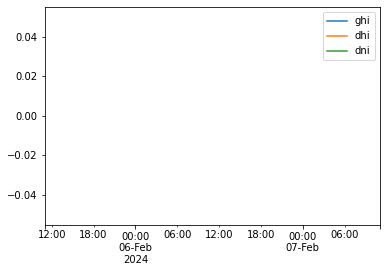

In [13]:
from weather_forecast import weather_forecaster_singlelocation
import datetime
from fmlc.baseclasses import eFMU
import pandas as pd

class weather_forecaster(eFMU):
    '''
    This class gathers the weather forecast using pvlib's HRRR tool.
    '''
    def __init__(self):
        
        self.input = {'location': None, 'coordinates': None, 'timezone': None, 'start': None}
        self.output = {'output-data': None}

    def compute(self):
        '''
        This method gathers the specified weather forecast and returns either the forecast
        or an error message.
        
        Inputs are provided by changing the class attributes, not by passing them to this method.
        locaiton: The location of the targeted weather forecast. A descriptive name. e.g. 'B71t'
        coordinates: A list expressing the longitude ([0]) and latitude ([1]) of the desired forecast location.
        timezone: The timezone of the desired forecast location.
        start: Either a string representing the desired starting time of the forecast, or False.
               This method will use the start of the current hour (e.g. At 12:09 it will use 12) if start is False.
               Note that pvlib rounds start time up, so passing a start time of 8:25 will return a forecast starting
               at 9.
               
        The output forecast is saved to self.output['output-data'], and the method returns 'Done.'. If an error 
            occurs the saved forecast will be blank and the method will return an error message.
        '''

        #Parse inputs
        config = {}
        config['location'] = self.input['location']
        config['coordinates'] = self.input['coordinates']
        config['timezone'] = self.input['timezone']
        config['start'] = self.input['start']
        if config['start'] != False:
            config['start'] = pd.Timestamp(datetime.datetime.strptime(config['start'], "%Y-%m-%d %H:%M:%S"))
            
        # Initialize forecaster model
        forecaster = weather_forecaster_singlelocation(config, coordinates = True)
        
        # Gather forecast
        # Returns forecast as dataframe and string error message
        forecast, error_msg = forecaster.get_forecasts(start = config['start'], return_result = True)
        print(forecast.index[0])
        forecast.index = forecast.index.tz_localize(None)
        
        # Write outputs
        self.output['output-data'] = forecast.to_json()

        # Return status message
        if len(error_msg) > 0:
            return error_msg
        else:
            return 'Done.' 

if __name__ == '__main__':
    
    # Initialize forecaster
    forecaster = weather_forecaster()
    
    '''
    # Test receiving an error message  
    # This test should print an error message stating that the specified time is not available
    # Create and assign input data
    input_data = {'location': 'Camp Parks',
                  'coordinates': [-121.9101, 37.7159],
                  'timezone': 'Etc/GMT+8',
                  'start': datetime.datetime(2020, 11, 4, 3).strftime("%Y-%m-%d %H:%M:%S")
                 }
    
    # Get error message
    message = forecaster.do_step(inputs = input_data) 
    print(message)
    '''

    # Test gathering forecast at specified time, passing now as string.
    # HRRR stores forecasts for a few days, hard-coding a time will cause errors when out of date
    # Create and assign input data
    input_data = {'location': 'Camp Parks',
                  'coordinates': [-121.9101, 37.7159],
                  'timezone': "Etc/GMT+8",
                  #'start': datetime.datetime.strptime("24-01-25 12:01:01", "%y-%m-%d %H:%M:%S")
                  'start': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                 }

    
    
    # Get error message
    message = forecaster.do_step(inputs = input_data) 

    # Plot unit test outputs
    import pandas as pd
    result = pd.read_json(forecaster.output['output-data'])
    print(result)
    
    result[['temp_air']].plot()
    result[['ghi', 'dhi', 'dni']].plot()   
    
    # Test gathering forecast at UNspecified time
    # This is the expected use for ESTCP
    # Create and assign input data
    input_data = {'location': 'Camp Parks',
                  'coordinates': [-121.9101, 37.7159],
                  'timezone': "Etc/GMT+8",
                  'start': False
                 }
    
    # Get forecast or error message
    message = forecaster.do_step(inputs = input_data) 

    # Plot unit test outputs
    result = pd.read_json(forecaster.output['output-data'])
    
    result[['temp_air']].plot()
    result[['ghi', 'dhi', 'dni']].plot()  